In [1]:
#LSST z-pred for syst-only sims run with SALT3 on NERSC
#List of systematics: 5mas, 10mas, 20mas syst floor, lcfit+z/fmax-clump tobs, color marginaliztion, x1 marginalization


%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import astropy
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib
import glob

import time
import sys
import os
import pandas as pd

import astropy.units as u
from astropy.coordinates import Angle, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
from astropy.coordinates import Angle

from scipy import interpolate

import galsim
from scipy import ndimage

# location of CTIO
earth_location = EarthLocation.of_site('La Silla Observatory')

print(earth_location)

(1838554.9580025, -5258914.42492168, -3099898.78073271) m


In [3]:
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [4]:
font = {'family' : 'serif',
        'weight' : 'bold',
        'style'  : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)

In [5]:
ref_star_SED = np.loadtxt('/global/cfs/cdirs/des/jlee/SN_Ia/star_SEDs/ukk5v.dat')

f_source = interp1d(ref_star_SED.transpose()[0], ref_star_SED.transpose()[1])

LSST_bands = ['u', 'g', 'r', 'i', 'z', 'Y']
band_colors = ['blue', 'green', 'red', 'orange', 'violet']

SNANA_lsst_bands = []
for i in range(len(LSST_bands[:-1])):
    SNANA_lsst_bands.append(np.loadtxt('DCR_AstroZ/filter_functions/LSST_baseline_1.9/LSST_' + LSST_bands[i] + '.dat', skiprows = 7))


In [6]:
def sky_to_alt_az_coords(SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    alt, az = coord0.transform_to(aa).alt, coord0.transform_to(aa).az 
    return alt, az

def sky_to_alt_az_shift(DCR_shift_RA, DCR_shift_DEC, SN_fid_pos, mjd, loc = earth_location):
    coord0 = SkyCoord(SN_fid_pos[0] * u.deg, SN_fid_pos[1] * u.deg)
    aa = AltAz(location=loc, obstime=Time(mjd, scale = 'utc', format = 'mjd', location = loc))
    coord = SkyCoord((coord0.ra.value + DCR_shift_RA) * u.deg, (coord0.dec.value + DCR_shift_DEC) * u.deg)
    alt_shift, az_shift = coord.transform_to(aa).alt - coord0.transform_to(aa).alt, coord.transform_to(aa).az - coord0.transform_to(aa).az
    return alt_shift, az_shift

In [7]:
def find_nearest(array, values):
    array = np.asarray(array)
    idxs = np.zeros(len(values))
    for i in range(len(values)):
        idxs[i] = (np.abs(array - values[i])).argmin()
    idxs = idxs.astype(int)
    return idxs, array[idxs]

In [28]:
dir_str = 'JASON_DCR_ASTROZ_COADD_SYST_ONLY_v1113/'
SIM_dir_str = '/pscratch/sd/a/astjason/DCR_AstroZ/' + dir_str
t_head = Table.read(glob.glob(SIM_dir_str + '*HEAD.FITS*')[0])
t_phot = Table.read(glob.glob(SIM_dir_str + '*PHOT.FITS*')[0])
t_DCR = pd.read_csv(glob.glob(SIM_dir_str + '*.DCR*')[0], delim_whitespace=True, skiprows = 6)
t_DUMP = pd.read_csv(glob.glob(SIM_dir_str + '*.DUMP*')[0], delim_whitespace=True, skiprows = 5)

SIM_dir_str_2mas = '/pscratch/sd/a/astjason/DCR_AstroZ/JASON_DCR_ASTROZ_SYST_ONLY_COADD_2mas/'
t_head_2mas = Table.read(glob.glob(SIM_dir_str_2mas + '*HEAD.FITS*')[0])
t_DCR_2mas = pd.read_csv(glob.glob(SIM_dir_str_2mas + '*.DCR*')[0], delim_whitespace=True, skiprows = 6)
t_DUMP_2mas = pd.read_csv(glob.glob(SIM_dir_str_2mas + '*.DUMP*')[0], delim_whitespace=True, skiprows = 5)


In [29]:
z_true = t_head['REDSHIFT_FINAL']
z_true_2mas = t_head_2mas['REDSHIFT_FINAL']

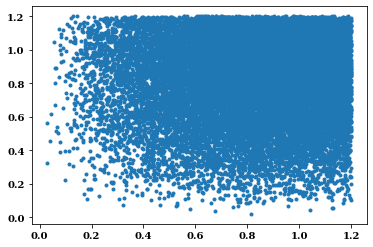

In [30]:
plt.plot(z_true, z_true_2mas, '.')

In [53]:
where_epoch_condition = np.loadtxt(SIM_dir_str + 'where_epoch_condition').astype(int)
where_epoch_condition_2mas = np.loadtxt(SIM_dir_str_2mas + 'where_epoch_condition').astype(int)

In [41]:
floor_strs = ['2mas', '5mas', '10mas']

z_preds_wrt_zY_floor = np.zeros([len(floor_strs), 2, len(t_head)])

for i in range(len(floor_strs)):
    z_preds_wrt_zY_floor_each = np.load('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_ideal_tobs_%s.npy' %floor_strs[i])
    a, b = z_preds_wrt_zY_floor_each[0].transpose()[0], z_preds_wrt_zY_floor_each[1].transpose()[0]
    z_preds_wrt_zY_floor[i] = a, b

In [42]:
# Now adding RMS/sqrt(n) (error on the mean) [0]: Bias, [1]: RMS error, [2]: Error on the mean, [3]: Outlier rates eta_0.10, [4]: sigma_MAD
def residuals_exp_and_outliers_and_MAD(z_pred_val, z_true_val, zcut_range = np.linspace(0, 1.2, num = 13)):
    exp_vals = np.zeros([len(zcut_range)-1, 5])#, np.zeros([len(zcut_range)-1])
    for z in range(len(zcut_range)-1):
        where_z_range = np.where((z_true_val > zcut_range[z]) & (z_true_val <= zcut_range[z+1]))[0]
        true_vals, pred_vals = z_true_val[where_z_range], z_pred_val[where_z_range]
        Delta_z = (pred_vals - true_vals)/(1 + true_vals)
        exp_vals[z] = np.mean(Delta_z), np.std(Delta_z), np.std(Delta_z)/np.sqrt(len(Delta_z)), len(np.where(abs(Delta_z.value)>0.10)[0])/len(Delta_z.value), 1.4826*np.median(abs(Delta_z - np.median(Delta_z)))
    return exp_vals#, outlier_rates

In [54]:
print(residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[0][0][where_epoch_condition_2mas], z_true_2mas[where_epoch_condition_2mas], np.linspace(0, 1.2, num = 2)))
print(residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[0][1][where_epoch_condition_2mas], z_true_2mas[where_epoch_condition_2mas], np.linspace(0, 1.2, num = 2)))

for i in range(2):
    print(residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[i+1][0][where_epoch_condition], z_true[where_epoch_condition], np.linspace(0, 1.2, num = 2)))
    print(residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[i+1][1][where_epoch_condition], z_true[where_epoch_condition], np.linspace(0, 1.2, num = 2)))

[[-0.00663065  0.03338528  0.00028392  0.01489839  0.00877267]]
[[-0.00292446  0.03457507  0.00029404  0.01627251  0.00891199]]
[[-0.01025631  0.0412235   0.00035065  0.02807322  0.01147899]]
[[-0.00423964  0.04285368  0.00036452  0.02402142  0.01086658]]
[[-0.01901395  0.05313244  0.00045195  0.06482888  0.01863982]]
[[-0.00697802  0.0526732   0.00044804  0.04572752  0.01519015]]


In [56]:
z_preds_wrt_zY_all_syst_for_realistic = np.load('DCR_AstroZ/results/Data_for_Paper/systematics/z_preds_wrt_zY_all_syst_for_realistic.npy')
a, b = z_preds_wrt_zY_all_syst_for_realistic[0].transpose()[0], z_preds_wrt_zY_all_syst_for_realistic[1].transpose()[0]
z_preds_wrt_zY_all_syst_for_realistic = a, b

In [58]:
print(residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_all_syst_for_realistic[0][where_epoch_condition], z_true[where_epoch_condition], np.linspace(0, 1.2, num = 2)))
print(residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_all_syst_for_realistic[1][where_epoch_condition], z_true[where_epoch_condition], np.linspace(0, 1.2, num = 2)))

[[-0.00965853  0.06081148  0.00051727  0.06374358  0.01559224]]
[[-0.00361328  0.06425676  0.00054657  0.07314956  0.01444733]]


In [60]:
dir_str_perfect = 'DCR_AstroZ/results/Data_for_Paper/perfect/'

In [67]:
# c, x1 marg, realistic tobs

z_preds_wrt_zY_c_marg = np.load(dir_str_perfect + 'z_preds_wrt_zY_ideal_tobs_c_marg.npy')
a, b = z_preds_wrt_zY_c_marg[0].transpose()[0], z_preds_wrt_zY_c_marg[1].transpose()[0]
z_preds_wrt_zY_c_marg = a, b

z_preds_wrt_zY_x1_marg = np.load(dir_str_perfect + 'z_preds_wrt_zY_ideal_tobs_x1_marg.npy')
a, b = z_preds_wrt_zY_x1_marg[0].transpose()[0], z_preds_wrt_zY_x1_marg[1].transpose()[0]
z_preds_wrt_zY_x1_marg = a, b

z_preds_wrt_zY_realistic_tobs = np.load(dir_str_perfect + 'z_preds_wrt_zY_combined_with_lcfit_tobs_no_marg.npy')
a, b = z_preds_wrt_zY_realistic_tobs[0].transpose()[0], z_preds_wrt_zY_realistic_tobs[1].transpose()[0]
z_preds_wrt_zY_realistic_tobs = a, b

In [68]:
#240402

type_strs_selection = ['2mas', '5mas', '10mas', 'c_marg_only', 'x1_marg_only', 'realistic_tobs', 'all_syst']#, 'Peaks == CDF50']

where_type = where_epoch_condition

type_strs_stat = ['CDF50', 'Peaks']

for i in range(len(type_strs_stat)):
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[0], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[0][i][where_epoch_condition_2mas], z_true_2mas[where_epoch_condition_2mas], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[1][i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[2], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[2][i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_c_marg[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_x1_marg[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[5], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_realistic_tobs[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 13)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_binned_eta0.10.txt' %(type_strs_selection[6], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_all_syst_for_realistic[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 13)))

    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[0], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[0][i][where_epoch_condition_2mas], z_true_2mas[where_epoch_condition_2mas], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[1][i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[2], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[2][i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_c_marg[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_x1_marg[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[5], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_realistic_tobs[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 3)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_high_low_z_eta0.10.txt' %(type_strs_selection[6], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_all_syst_for_realistic[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 3)))

    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[0], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[0][i][where_epoch_condition_2mas], z_true_2mas[where_epoch_condition_2mas], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[1], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[1][i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[2], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_floor[2][i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[3], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_c_marg[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[4], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_x1_marg[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[5], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_realistic_tobs[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 2)))
    np.savetxt('DCR_AstroZ/results/Data_for_Paper/systematics/z_metrics_type_%s_%s_syst_only_all_z_eta0.10.txt' %(type_strs_selection[6], type_strs_stat[i]), residuals_exp_and_outliers_and_MAD(z_preds_wrt_zY_all_syst_for_realistic[i][where_type], z_true[where_type], np.linspace(0, 1.2, num = 2)))

